In [197]:
import cv2
import numpy as np
import  kociemba
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import skimage as sk
import skimage.io as skio
import scipy.cluster
import sklearn.cluster

In [219]:
def show_img (img):
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    rbg_pic = np.dstack([r,g,b])
    plt.imshow(rbg_pic)
    plt.show()
    

# Manual selector three points to locate the cube for now.
# Switch to auto Later 
# https://web.archive.org/web/20121207001334/http://www.cs.ubc.ca/~andrejk/525project/525report.pdf

def manual_sel_ptr(img):
    %matplotlib qt
    pic_f = sk.img_as_float(img)
    plt.imshow(pic_f)
    pts = np.asarray(plt.ginput(-1, timeout=60))
    %matplotlib inline
    min_x = pts[0][0]
    max_x = pts[1][0]
    min_y = pts[0][1]
    max_y = pts[2][1]
    return (min_x , max_x, min_y, max_y)

# Crop the image into base on the args 
def crop_img (img, min_x, max_x, min_y, max_y):
    crop = img[int(min_x): int(max_x), int(min_y):int(max_y)]
    return crop

# Tiles to image into 3x3
def tile_img_9(img):
    M = img.shape[0]//3
    N = img.shape[1]//3
    tiles = []
    for x in range(0,img.shape[0],M):
        for y in range(0,img.shape[1], N):
            if (x + M > img.shape[0] or y + N > img.shape[1]):
                continue
            tiles.append(img[x:x+M,y:y+N])
    return tiles

# Using the Knn to find the most dominate color in a giving img
def dominant_colors(image):
    image = cv2.resize(image, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    kmeans = sklearn.cluster.MiniBatchKMeans(
        n_clusters=5,
        init="k-means++",
        max_iter=20,
        random_state=1000
    ).fit(ar)
    codes = kmeans.cluster_centers_

    vecs, _dist = scipy.cluster.vq.vq(ar, codes)
    counts, _bins = np.histogram(vecs, len(codes))

    colors = []
    for index in np.argsort(counts)[::-1]:
        colors.append(tuple([int(code) for code in codes[index]]))
    return colors

color_palette = {
            'red'   : (0, 0, 255),
            'orange': (0, 165, 255),
            'blue'  : (255, 0, 0),
            'green' : (0, 255, 0),
            'white' : (255, 255, 255),
            'yellow': (0, 255, 255)
}

# least Square to find the corresponding color
def closest_color(bgr):
    b, g, r = bgr
    color_diffs = []
    for name, color in color_palette.items():
        cb, cg, cr = color
        color_diff = np.sqrt((r - cr)**2 + (g - cg)**2 + (b - cb)**2)
        color_diffs.append((color_diff, name))
    return min(color_diffs)[1]

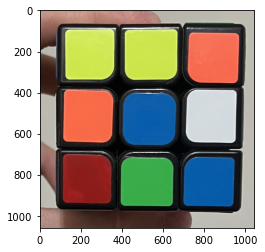

In [208]:
pic = cv2. imread("Cube.jpg")
show_img(pic)

In [209]:
pts = manual_sel_ptr(pic)

In [210]:
# min_x , max_x, min_y, max_y = pts
# plt.figure(figsize=(5, 5))
# plt.imshow(rbg_pic)
# plt.scatter(min_x, min_y)
# plt.scatter(max_x, min_y)
# plt.scatter(min_x, max_y)
# plt.scatter(max_x, max_y)
# plt.scatter(*pts[0])
# plt.show()

In [211]:
crop = crop_img(pic, *pts)

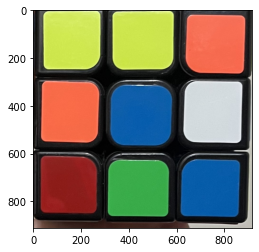

In [212]:
show_img(crop)

In [213]:
tiles = tile_img_9(crop)

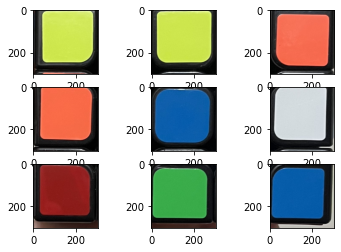

In [220]:
for i, t in enumerate(tiles):
    plt.subplot(3,3,i + 1)
    r = t[:,:,2]
    g = t[:,:,1]
    b = t[:,:,0]
    rbg_pic = np.dstack([r,g,b])
    plt.imshow(rbg_pic)
plt.show()

In [225]:
colors = dominant_colors(tiles[4])

In [226]:
face_color = []
for i in tiles:
    colors = dominant_colors(i)
    face_color.append(closest_color(colors[0]))
face_color

['yellow',
 'yellow',
 'orange',
 'orange',
 'blue',
 'white',
 'red',
 'green',
 'blue']